In [1]:
%%capture
!pip install --upgrade kaggle-environments chessnut

In [2]:
# Import libraries
from kaggle_environments import make

No pygame installed, ignoring import


In [3]:
%%writefile main.py
from Chessnut import Game
import random

# Global set to track moved pieces
moved_pieces = set()
moves_count = {}  # Track how many times each piece has moved
history_table = {}  # History heuristic table

PIECE_VALUES = {"P": 1, "N": 3, "B": 3, "R": 5, "Q": 9, "K": 100,
                "p": -1, "n": -3, "b": -3, "r": -5, "q": -9, "k": -100}

REGIONS = {
    "center": [27, 28, 35, 36],  # d4, d5, e4, e5
    "extended_center": [18, 19, 20, 21, 26, 29, 34, 37, 42, 43, 44, 45],  # c3-f6
    "king_side": [5, 6, 13, 14, 21, 22],  # g1-g4
    "queen_side": [1, 2, 9, 10, 17, 18]  # b1-b4
}

POSITIONAL_BONUS = {
    "P": [0, 5, 5, 10, 10, 20, 30, 0],
    "p": [0, -5, -5, -10, -10, -20, -30, 0]
}


# Helper functions
def fen_to_board_array(fen):
    """Convert a FEN string to a flat list representing the chessboard."""
    board = []
    for row in fen.split()[0].split('/'):
        for char in row:
            if char.isdigit():
                board.extend([" "] * int(char))
            else:
                board.append(char)
    return board


def get_piece_id(move, board_array):
    """Retrieve the ID of the piece making the move."""
    start_square = Game.xy2i(move[:2])
    return board_array[start_square]


def validate_piece_move(move, board_array):
    """Ensure no piece moves twice consecutively and moves are highly distributed."""
    global moved_pieces, moves_count

    # Convert move to piece ID
    piece_id = get_piece_id(move, board_array)

    # Avoid consecutive moves by the same piece
    if piece_id in moved_pieces:
        return False

    # Track the number of moves for the piece
    moves_count[piece_id] = moves_count.get(piece_id, 0) + 1

    # If all pieces have moved, reset the cycle
    if len(moved_pieces) == 16:
        moved_pieces.clear()

    # Add piece to the moved pieces set
    moved_pieces.add(piece_id)
    return True


def is_move_safe(move, board_array, obs_board):
    """Check if a move is safe (i.e., does not result in immediate loss of a piece)."""
    board = Game(obs_board)
    board.apply_move(move)
    opponent_moves = list(board.get_moves())
    target_square = Game.xy2i(move[2:4])

    # Check if any opponent move can capture the piece after this move
    for opponent_move in opponent_moves:
        if Game.xy2i(opponent_move[2:4]) == target_square:
            return False

    return True


def quick_evaluate(board_fen):
    """Lightweight board evaluation to score material advantage."""
    board = fen_to_board_array(board_fen)
    return sum(PIECE_VALUES.get(piece, 0) for piece in board)


def evaluate_regional_dominance(board_array, phase):
    """Evaluate control over key regions on the board, with dynamic weighting based on game phase."""
    dominance_score = 0
    weights = {
        "early": {"center": 3, "extended_center": 2, "king_side": 1, "queen_side": 1},
        "mid": {"center": 2, "extended_center": 2, "king_side": 2, "queen_side": 2},
        "end": {"center": 1, "extended_center": 1, "king_side": 3, "queen_side": 3}
    }[phase]

    for region, squares in REGIONS.items():
        for square in squares:
            piece = board_array[square]
            if piece.isupper():  # White pieces
                dominance_score += weights[region]
            elif piece.islower():  # Black pieces
                dominance_score -= weights[region]
    return dominance_score


def positional_evaluation(board_array):
    """Add positional heuristics such as king safety, pawn structure, rook mobility, and bishop pair."""
    king_safety = 0
    pawn_structure = 0
    rook_mobility = 0
    bishop_pair = 0

    white_bishops = 0
    black_bishops = 0

    for i, piece in enumerate(board_array):
        if piece == "K":
            king_safety += 1 if i in REGIONS["king_side"] else -1
        elif piece == "k":
            king_safety -= 1 if i in REGIONS["king_side"] else 1
        elif piece in "Pp":
            pawn_structure += 0.5 if i in REGIONS["center"] else 0
        elif piece == "R":
            rook_mobility += 1 if i % 8 in [3, 4] else 0  # Open or semi-open file
        elif piece == "r":
            rook_mobility -= 1 if i % 8 in [3, 4] else 0
        elif piece == "B":
            white_bishops += 1
        elif piece == "b":
            black_bishops += 1

    if white_bishops == 2:
        bishop_pair += 0.5
    if black_bishops == 2:
        bishop_pair -= 0.5

    return king_safety + pawn_structure + rook_mobility + bishop_pair


def prioritize_moves(moves, obs_board, board_array):
    """Categorize and prioritize moves based on strategy, positional heuristics, regional dominance, and safety."""
    checkmate_moves = []
    capture_moves = []
    strategic_moves = []

    phase = determine_game_phase(board_array)

    for move in moves:
        # Skip unsafe moves
        if not is_move_safe(move, board_array, obs_board):
            continue

        # Apply move
        board = Game(obs_board)
        board.apply_move(move)

        # Checkmate detection
        if board.status == Game.CHECKMATE:
            checkmate_moves.append(move)
            continue

        # Check if the move results in capturing a piece
        target_square = Game.xy2i(move[2:4])
        if board_array[target_square] not in " ":
            capture_moves.append((move, PIECE_VALUES.get(board_array[target_square].upper(), 0)))
            continue

        # Strategic moves (evaluated by material advantage, regional dominance, and positional heuristics)
        score = (quick_evaluate(board.get_fen()) +
                 evaluate_regional_dominance(fen_to_board_array(board.get_fen()), phase) +
                 positional_evaluation(fen_to_board_array(board.get_fen())))

        # Record move in history table
        history_table[move] = history_table.get(move, 0) + score
        strategic_moves.append((move, score))

    # Sort moves by history heuristic score
    strategic_moves.sort(key=lambda x: history_table.get(x[0], 0), reverse=True)

    return checkmate_moves, capture_moves, strategic_moves


def determine_game_phase(board_array):
    """Determine the current phase of the game based on material count."""
    piece_count = sum(1 for piece in board_array if piece in PIECE_VALUES)
    if piece_count > 20:
        return "early"
    elif piece_count > 10:
        return "mid"
    else:
        return "end"


def chess_bot(obs):
    """Chess bot enforcing alternation of pieces, regional dominance, advanced heuristics, and safe moves."""
    game = Game(obs.board)
    moves = list(game.get_moves())
    if not moves:
        return "0000"  # No legal moves

    # Convert the board to an array
    board_array = fen_to_board_array(obs.board)

    # Filter moves based on alternation and distribution restriction
    valid_moves = [move for move in moves if validate_piece_move(move, board_array)]

    # If no valid moves remain due to the restriction, reset cycle and allow any legal move
    if not valid_moves:
        moved_pieces.clear()
        valid_moves = moves

    # Prioritize moves
    checkmate_moves, capture_moves, strategic_moves = prioritize_moves(
        valid_moves, obs.board, board_array
    )

    # Decide the best move
    if checkmate_moves:
        return random.choice(checkmate_moves)
    if capture_moves:
        return max(capture_moves, key=lambda x: x[1])[0]  # Choose the highest value capture
    if strategic_moves:
        return max(strategic_moves, key=lambda x: x[1])[0]

    # Default fallback
    return random.choice(valid_moves)


Writing main.py


In [4]:
# Initialize the Kaggle chess environment
env = make("chess", debug=True)

# Run the game: Bot vs Random agent
result = env.run(["main.py", "random"])


Agent exit status/reward/time left: 
	 DONE / 1 / 3.931962999999998
	 DONE / 0 / 10





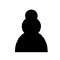
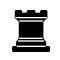
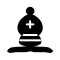
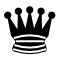
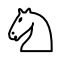
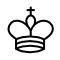
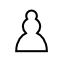
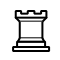
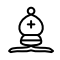
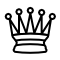
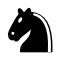
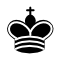

In [5]:
# Display agent results
print("Agent exit status/reward/time left: ")
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")

# Render the game visually
env.render(mode="ipython", width=1000, height=1000)
